# IMDB Reviews Classification
### Language Model vs End-to-End

##### Setup

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd "/content/drive/MyDrive/Colab Notebooks"
# %ls

In [3]:
# !wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar xvzf aclImdb_v1.tar.gz

In [4]:
import os
import re
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_sequence, unpack_sequence
from torch.utils.data import Dataset, DataLoader

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')

import gensim.downloader
glove = gensim.downloader.load('glove-wiki-gigaword-50')

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##### Load the data

In [5]:
def read_reviews(dir_path, max_read=None):
    review_files = os.listdir(dir_path)
    print(f"{len(review_files)} files to read")
    
    random.seed(42)
    review_files = random.sample(review_files, max_read) if max_read else review_files
    print(f"Read {len(review_files)} reviews from {dir_path}")

    reviews = []
    for review_file in review_files:
        with open(os.path.join(dir_path, review_file)) as f:
            reviews.append(f.read())

    return reviews, [int(re.findall(r'_(\d+)', filename)[0]) for filename in review_files]

In [6]:
TRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/aclImdb/train"
TEST_PATH = "/content/drive/MyDrive/Colab Notebooks/aclImdb/test"
NEGATIVE_DIR = "neg"
POSITIVE_DIR = "pos"
UNLABELED_DIR = "unsup"

SAMPLE_SIZE = 10
VAL_SIZE = 0.2

In [7]:
train_pos_text, train_pos_rating = read_reviews(os.path.join(TRAIN_PATH, POSITIVE_DIR), SAMPLE_SIZE)
train_neg_text, train_neg_rating = read_reviews(os.path.join(TRAIN_PATH, NEGATIVE_DIR), SAMPLE_SIZE)
train_unlabeled_text, _ = read_reviews(os.path.join(TRAIN_PATH, UNLABELED_DIR), SAMPLE_SIZE)

train_pos_text, val_pos_text, train_pos_rating, val_pos_rating = train_test_split(train_pos_text, train_pos_rating, test_size=VAL_SIZE, random_state=42)
train_neg_text, val_neg_text, train_neg_rating, val_neg_rating = train_test_split(train_neg_text, train_neg_rating, test_size=VAL_SIZE, random_state=42)
train_unlabeled_text, val_unlabeled_text = train_test_split(train_unlabeled_text, test_size=VAL_SIZE, random_state=42)

test_pos_text, test_pos_rating = read_reviews(os.path.join(TEST_PATH, POSITIVE_DIR), SAMPLE_SIZE)
test_neg_text, test_neg_rating = read_reviews(os.path.join(TEST_PATH, NEGATIVE_DIR), SAMPLE_SIZE)

12500 files to read
Read 10 reviews from /content/drive/MyDrive/Colab Notebooks/aclImdb/train/pos
12500 files to read
Read 10 reviews from /content/drive/MyDrive/Colab Notebooks/aclImdb/train/neg
10745 files to read
Read 10 reviews from /content/drive/MyDrive/Colab Notebooks/aclImdb/train/unsup
12500 files to read
Read 10 reviews from /content/drive/MyDrive/Colab Notebooks/aclImdb/test/pos
12500 files to read
Read 10 reviews from /content/drive/MyDrive/Colab Notebooks/aclImdb/test/neg


In [8]:
len(train_pos_text), len(val_pos_text), len(test_pos_text)

(8, 2, 10)

## 1 Language Modeling

### 1.1 Data Exploration & Analysis

Check for line break tags

In [9]:
LINE_BREAK = '<br />'

count = 10
for text in train_pos_text:
    if LINE_BREAK in text:
        print(text)
        count -= 1
        if count == 0:
            break

I have always liked this comedy as one of the few ever seriously trying to deal with the U.S. Government's yearly demand for taxes. Ever read a tax code?: it is quite a trial to follow it's multiple clauses that our congressmen and senators push in to help their financial backers and various interest groups. Despite claims that it is fair, the tax code has always laid the lion share of the burden on the middle and working classes rather than the rich and influential. Most of the various special clauses are meant for their use - go through the average 1040 or 1040A form and look at the variety of different investment and business ventures all of which have a different set of rules. Most people will never have any use for these.<br /><br />The story here is that a wealthy landowner (Philip Ober) uses his influence to tip off the IRS that his neighbors (Paul Douglas and Una Merkle) have not payed taxes in 20 years. The Baltimore office of the IRS is under Fred Clarke, and he is snapping t

In [10]:
def count_line_break_usage(reviews):
    count = 0
    for i, t in enumerate(reviews):
        if LINE_BREAK in t:
            count += 1
    return count

In [11]:
print(count_line_break_usage(train_pos_text),
      count_line_break_usage(train_neg_text))

3 5


Some many line breaks.. we will need to deal with them.\
We will surround them with spaces and remove spaces inside the tags.

In [12]:
NEW_LINE_BREAK = ' '

train_pos_text = [text.replace(LINE_BREAK, NEW_LINE_BREAK) for text in train_pos_text]
train_neg_text = [text.replace(LINE_BREAK, NEW_LINE_BREAK) for text in train_neg_text]
train_unlabeled_text = [text.replace(LINE_BREAK, NEW_LINE_BREAK) for text in train_unlabeled_text]
val_pos_text = [text.replace(LINE_BREAK, NEW_LINE_BREAK) for text in val_pos_text]
val_neg_text = [text.replace(LINE_BREAK, NEW_LINE_BREAK) for text in val_neg_text]

In [13]:
print(count_line_break_usage(train_pos_text),
      count_line_break_usage(train_neg_text))

0 0


Let's tokenize the reviews

In [14]:
# tokenizer = Tokenizer(English().vocab)

In [15]:
# def tokenize_reviews(reviews):
#     return [tokenizer(review) for review in reviews]

In [16]:
# train_pos_tokens = tokenize_reviews(train_pos_text)
# train_neg_tokens = tokenize_reviews(train_neg_text)

Let's count tokens

In [17]:
# all_tokens = list(set([
#     tok.text
#     for review in train_pos_tokens + train_neg_tokens
#     for tok in review
# ]))

# tok2id = { tok: i for i, tok in enumerate(all_tokens) }

In [18]:
# def count_tokens(tokenized_reviews):
#     return Counter([
#         tok2id[tok.text]
#         for review in tokenized_reviews
#         for tok in review
#     ])

In [19]:
# pos_token_counter = count_tokens(train_pos_tokens)
# neg_token_counter = count_tokens(train_neg_tokens)

Let's compare the usage of some meaningful words

In [20]:
# meaningful_words = ['best', 'love', 'fantastic', 'terrific', 'horrible', 'worst', 'bad']

# for word in meaningful_words:
#     pos = pos_token_counter[tok2id[word]]
#     neg = neg_token_counter[tok2id[word]]
#     print(f"{word}: {pos=}, {neg=}")

### 1.2 Dataset & Dataloader

In [21]:
class LanguageModelDataset(Dataset):
    def __init__(self, texts, word2id=None):

        # Special characters
        self.start = '<START>'
        self.end = '<END>'
        self.unknown = '<UNKNOWN>'

        # Actual pairs of samples
        self.X = []
        self.y = []

        # Construct the actual dataset
        self.__create_dataset(texts, word2id)

    def __create_dataset(self, texts, word2id):  

        # Construct token hierarchy
        tokens = [
            [self.start] + word_tokenize(s) + [self.end] 
            for text in texts
            for s in sent_tokenize(text)
        ]

        # Build vocabulary
        if word2id == None:

            # Token set
            word2id = []
            for s in tokens:
                word2id = list(set(word2id + s))
            
            # Make word-to-id dictionary
            num_words = len(word2id)
            word2id = {word: i for i, word, in enumerate(word2id)} | {self.unknown: len(word2id)}

        self.word2id = {word: i for word, i in word2id.items()}
        self.id2word = {i: word for word, i in word2id.items()}

        # For each target word in each sentence
        for s in tokens:
            for i, wi in enumerate(s[1:], start=1):

                # word ids
                self.X.append([self.word2id.get(w, self.word2id[self.unknown]) for w in s[:i]])

                # target word id
                self.y.append(self.word2id.get(wi, self.word2id[self.unknown]))

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [22]:
lm_train_text = train_pos_text + train_neg_text + train_unlabeled_text
lm_val_text = val_pos_text + val_neg_text + val_unlabeled_text
lm_test_text = test_pos_text + test_neg_text

lm_train_ds = LanguageModelDataset(lm_train_text)
lm_val_ds = LanguageModelDataset(lm_val_text, word2id=lm_train_ds.word2id)
lm_test_ds = LanguageModelDataset(lm_test_text, word2id=lm_train_ds.word2id)

In [23]:
len(lm_train_ds.word2id), len(lm_val_ds.word2id), len(lm_test_ds.word2id)

(1779, 1779, 1779)

In [24]:
print(len(lm_train_ds))
for i in range(20):
    x, y = lm_train_ds[i]
    print(x, y)

print(lm_train_ds.word2id['<START>'])
print(lm_train_ds.word2id['<END>'])
print(lm_train_ds.word2id['<UNKNOWN>'])

6201
[993] 971
[993, 971] 213
[993, 971, 213] 1385
[993, 971, 213, 1385] 125
[993, 971, 213, 1385, 125] 983
[993, 971, 213, 1385, 125, 983] 71
[993, 971, 213, 1385, 125, 983, 71] 1646
[993, 971, 213, 1385, 125, 983, 71, 1646] 1733
[993, 971, 213, 1385, 125, 983, 71, 1646, 1733] 1578
[993, 971, 213, 1385, 125, 983, 71, 1646, 1733, 1578] 249
[993] 919
[993, 919] 595
[993, 919, 595] 1299
[993, 919, 595, 1299] 1746
[993, 919, 595, 1299, 1746] 71
[993, 919, 595, 1299, 1746, 71] 125
[993, 919, 595, 1299, 1746, 71, 125] 1035
[993, 919, 595, 1299, 1746, 71, 125, 1035] 463
[993, 919, 595, 1299, 1746, 71, 125, 1035, 463] 1271
[993, 919, 595, 1299, 1746, 71, 125, 1035, 463, 1271] 914
993
249
1778


In [25]:
def my_collate_fn(batch):
    features = pack_sequence([torch.tensor(sample[0], dtype=torch.long) for sample in batch], enforce_sorted=False)
    labels = torch.tensor([sample[1] for sample in batch], dtype=torch.long)
    return features, labels

In [26]:
lm_train_dl = DataLoader(lm_train_ds, batch_size=64, shuffle=True, collate_fn=my_collate_fn)
lm_val_dl = DataLoader(lm_val_ds, batch_size=64, shuffle=True, collate_fn=my_collate_fn)
lm_test_dl = DataLoader(lm_test_ds, batch_size=64, shuffle=False, collate_fn=my_collate_fn)

### 1.3 Model Definition & Training

In [27]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, input_dim, cell_dim, num_layers=1):
        super().__init__()
        
        # Params
        self.cell_dim = cell_dim
        self.num_layers = num_layers

        # Net
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=input_dim)
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=cell_dim, num_layers=num_layers)
        self.fc1 = nn.Linear(in_features=cell_dim, out_features=min(cell_dim * 2, (cell_dim + vocab_size) // 2))
        self.fc2 = nn.Linear(in_features=min(cell_dim * 2, (cell_dim + vocab_size) // 2), out_features=vocab_size)

    def extract_features(self, x):

        # Select embeddings
        unpacked_x = unpack_sequence(x)
        batch_size = len(unpacked_x)
        embeddings = [self.embedding(sample) for sample in unpacked_x]
        packed_embeddings = pack_sequence(embeddings, enforce_sorted=False)

        # Initialize hidden & cell states for LSTM
        h_0 = torch.zeros(self.num_layers, batch_size, self.cell_dim)
        c_0 = torch.zeros(self.num_layers, batch_size, self.cell_dim)

        h_0 = h_0.to(device)
        c_0 = c_0.to(device)

        # Forward LSTM
        output, (h_n, c_n) = self.lstm(packed_embeddings, (h_0, c_0))

        return c_n[0]

    def forward(self, x):

        # Feature extractor
        feature_vec = self.extract_features(x)

        # Forward Fully-Connected
        pred = F.relu(self.fc1(feature_vec))
        pred = self.fc2(pred)

        return pred
        

In [28]:
lm = LanguageModel(vocab_size=len(lm_train_ds.id2word), input_dim=100, cell_dim=100, num_layers=1)
lm

LanguageModel(
  (embedding): Embedding(1779, 100)
  (lstm): LSTM(100, 100)
  (fc1): Linear(in_features=100, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=1779, bias=True)
)

In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lm.parameters())

lm.to(device)
lm.train()
num_epochs = 10
verbose_freq = len(lm_train_dl) // 10

for e in range(1, num_epochs+1):
    print(f"--------------- epoch {e} ---------------")

    running_loss = 0.
    last_loss = 0.

    for i, (X, y) in enumerate(lm_train_dl, start=1):

        # Use GPU
        X, y = X.to(device), y.to(device)

        # Reset optimizer
        optimizer.zero_grad()

        # Forward
        predictions = lm(X)

        # Backward
        loss = loss_fn(predictions, y)
        loss.backward()
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % verbose_freq == 0:
            last_loss = running_loss / verbose_freq
            running_loss = 0.
            print(f'  batch {i}/{len(lm_train_dl)} loss: {last_loss}')

    running_loss = 0.
    last_loss = 0.

    for i, (X, y) in enumerate(lm_val_dl, start=1):

        # Use GPU
        X, y = X.to(device), y.to(device)

        with torch.no_grad():

            # Forward
            predictions = lm(X)

            # Backward
            loss = loss_fn(predictions, y)

        # Gather data and report
        running_loss += loss.item()
        if i % verbose_freq == 0:
            last_loss = running_loss / verbose_freq
            running_loss = 0.
            print(f'    batch {i}/{len(lm_val_dl)} loss: {last_loss}')

    

--------------- epoch 1 ---------------
  batch 9/97 loss: 7.452740828196208
  batch 18/97 loss: 7.338129096561008
  batch 27/97 loss: 7.121575408511692
  batch 36/97 loss: 6.643550607893202
  batch 45/97 loss: 6.346931457519531
  batch 54/97 loss: 6.150883621639675
  batch 63/97 loss: 6.012138154771593
  batch 72/97 loss: 6.198944197760688
  batch 81/97 loss: 6.1797207196553545
  batch 90/97 loss: 6.028644879659017
    batch 9/54 loss: 6.449344476064046
    batch 18/54 loss: 6.652997281816271
    batch 27/54 loss: 6.381751007503933
    batch 36/54 loss: 6.501115375094944
    batch 45/54 loss: 6.517235067155626
    batch 54/54 loss: 6.52052985297309
--------------- epoch 2 ---------------
  batch 9/97 loss: 5.610856427086724
  batch 18/97 loss: 5.621898969014485
  batch 27/97 loss: 5.497463226318359
  batch 36/97 loss: 5.481791867150201
  batch 45/97 loss: 5.559280236562093
  batch 54/97 loss: 5.478906154632568
  batch 63/97 loss: 5.431829187605116
  batch 72/97 loss: 5.479471418592665

In [30]:
def generate(gpt, start, end, id2word, word2id, max_len=20):
    generated = [start]

    tok = word2id[start]
    word = start
    while True:

        # generate
        t = torch.tensor([tok]).to(device)
        p = pack_sequence([t])
        logits = gpt(p)
        topk = torch.topk(logits, k=5).indices[0]
        tok = random.sample([x.item() for x in topk], 1)[0]

        word = id2word[tok]
        generated.append(word)

        if word == end or len(generated) == max_len:
            break
    
    return ' '.join(generated)

generate(lm, 
         lm_train_ds.start,
         lm_train_ds.end,
         lm_train_ds.id2word,
         lm_train_ds.word2id)

'<START> He . from Cagney . <END>'

### 1.4 Evaluation

#### 1.4.1 Perplexity

## 2 Text Classification

### 2.1 Dataset & Dataloader

In [31]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, word2id=None):

        self.unknown = '<UNKNOWN>'

        # Construct the actual dataset
        self.__create_dataset(texts, labels, word2id)

    def __create_dataset(self, texts, labels, word2id):        
        # Extract tokens
        tokens = [word_tokenize(text) for text in texts]

        # Build vocabulary
        if word2id == None:

            # Collect words
            word2id = []
            for s in tokens:
                word2id = list(set(word2id + s))
            
            # Make word-to-id dictionary
            num_words = len(word2id)
            word2id = {word: i for i, word, in enumerate(word2id)} | {self.unknown: len(word2id)}

        # Word-Id maps
        self.word2id = {word: i for word, i in word2id.items()}
        self.id2word = {i: word for word, i in word2id.items()}

        # Build data
        self.y = labels
        self.X = [
            [self.word2id.get(w, self.word2id[self.unknown]) for w in s]
            for s in tokens
        ]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

    def encode(self, text):
        return [self.word2id[w] for w in word_tokenize(text)]

In [32]:
clf_train_text = train_neg_text + train_pos_text
clf_train_rating = [0 for _ in train_neg_rating] + [1 for _ in train_pos_rating]
clf_val_text = val_neg_text + val_pos_text
clf_val_rating = [0 for _ in val_neg_rating] + [1 for _ in val_pos_rating]
clf_test_text = test_neg_text + test_pos_text
clf_test_rating = [0 for _ in test_neg_rating] + [1 for _ in test_pos_rating]

clf_train_ds = TextClassificationDataset(clf_train_text, clf_train_rating)
clf_val_ds = TextClassificationDataset(clf_val_text, clf_val_rating, word2id=clf_train_ds.word2id)
clf_test_ds = TextClassificationDataset(clf_test_text, clf_test_rating, word2id=clf_train_ds.word2id)

In [33]:
print(len(clf_train_ds))
for i in range(10):
    x, y = clf_train_ds[i]
    print(x, y)

16
[788, 48, 166, 954, 97, 325, 156, 582, 825, 1037, 1266, 835, 955, 121, 1210, 930, 97, 174, 1186, 1006, 1147, 973, 1245, 440, 1188, 976, 143, 102, 1186, 1332, 1295, 426, 955, 1086, 999, 375, 954, 281, 955, 39, 606, 97, 615, 1186, 809, 1186, 1006, 676, 866, 501, 772, 1140, 97, 353, 88, 97, 702, 1336, 438, 266, 1295, 260, 141, 507, 1037, 842, 386, 1051, 954, 182, 1243, 1037, 955, 65, 1114, 39, 606, 97, 10, 566, 174, 1186, 1006, 161, 88, 201, 386, 1266, 710, 1269, 174, 48, 1302, 1033, 386, 1033, 534, 1030, 5, 999, 326, 58, 1196, 438, 386, 999, 934, 1147, 1186, 1317, 954, 776, 1037, 1310, 58, 97, 1211, 860, 1266, 980, 959, 58, 1043, 1037, 1196, 1037, 509, 161, 1037, 48, 985, 1186, 282, 1082, 114, 999, 477, 1324, 772, 1186, 160, 1186] 0
[208, 858, 94, 88, 1310, 58, 1173, 202, 342, 866, 972, 999, 1027, 578, 58, 561, 954, 97, 1110, 451, 917, 1186, 1103, 839, 97, 733, 295, 473, 661, 1286, 955, 457, 97, 756, 1033, 1329, 1269, 451, 973, 855, 1037, 386, 97, 747, 58, 866, 460, 88, 905, 853, 606,

In [34]:
clf_train_dl = DataLoader(clf_train_ds, batch_size=4, shuffle=True, collate_fn=my_collate_fn)
clf_val_dl = DataLoader(clf_val_ds, batch_size=4, shuffle=True, collate_fn=my_collate_fn)
clf_test_dl = DataLoader(clf_test_ds, batch_size=4, shuffle=False, collate_fn=my_collate_fn)

### 2.2 Model Definition

In [35]:
class TextClassifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        # Classifier
        self.fc1 = nn.Linear(in_features=num_features, out_features=num_features//2)
        self.fc2 = nn.Linear(in_features=num_features//2, out_features=num_classes)
        
    def extract_features(self, x):
        assert False, "This method has to be overriden!"

    def forward(self, x):

        # Extract features
        feature_vec = self.extract_features(x)

        # Forward Fully-Connected
        pred = F.relu(self.fc1(feature_vec))
        pred = self.fc2(pred)

        return pred
        

#### 2.2-A Language Model

In [36]:
class LanguageModelClassifier(TextClassifier):
    def __init__(self, lm, num_features, num_classes):
        super().__init__(num_features, num_classes)

        self.lm = lm

        for param in self.lm.parameters():
            param.requires_grad = False

    def extract_features(self, x):
        return self.lm.extract_features(x)        

In [37]:
lm_clf = LanguageModelClassifier(lm, num_features=100, num_classes=2)
lm_clf

LanguageModelClassifier(
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
  (lm): LanguageModel(
    (embedding): Embedding(1779, 100)
    (lstm): LSTM(100, 100)
    (fc1): Linear(in_features=100, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=1779, bias=True)
  )
)

#### 2.2-B End-to-End

In [38]:
class EndToEndTextClassifier(TextClassifier):
    def __init__(self, id2word, cell_dim, num_layers, num_classes):
        super().__init__(cell_dim * 2, num_classes)

        self.cell_dim = cell_dim
        self.num_layers = num_layers

        self.__build_embeddings(id2word)
        self.lstm = nn.LSTM(input_size=self.embedding.size(1), 
                            hidden_size=cell_dim, 
                            num_layers=num_layers,
                            bidirectional=True)

    def __build_embeddings(self, id2word):
        
        embedding_size = len(glove[0])
        num_embeddings = len(id2word) + 1

        self.embedding = torch.zeros(num_embeddings, embedding_size)
        self.unknown_id = len(id2word)

        # Select pretrained vectors
        for i, w in id2word.items():
            if w in glove:
                self.embedding[i] = torch.tensor(glove[w])

        self.embedding = self.embedding.to(device)

    def extract_features(self, x):

        # Select embeddings
        unpacked_x = unpack_sequence(x)
        batch_size = len(unpacked_x)
        embeddings = [self.embedding[sample] for sample in unpacked_x]
        packed_embeddings = pack_sequence(embeddings, enforce_sorted=False)

        # Initialize hidden & cell states for LSTM
        h_0 = torch.zeros(2 * self.num_layers, batch_size, self.cell_dim)
        c_0 = torch.zeros(2 * self.num_layers, batch_size, self.cell_dim)

        h_0 = h_0.to(device)
        c_0 = c_0.to(device)

        # Forward LSTM
        output, (h_n, c_n) = self.lstm(packed_embeddings, (h_0, c_0))

        return c_n.reshape(batch_size, -1)

In [39]:
e2e_clf = EndToEndTextClassifier(id2word=clf_train_ds.id2word, cell_dim=100, num_layers=1, num_classes=2)
e2e_clf

EndToEndTextClassifier(
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (lstm): LSTM(50, 100, bidirectional=True)
)

### 2.3 Training

#### 2.3-A Language Model

In [40]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lm_clf.parameters())

lm_clf.to(device)
lm_clf.train()
num_epochs = 10
verbose_freq = 1

for e in range(1, num_epochs+1):
    print(f"--------------- epoch {e} ---------------")

    running_loss = 0.
    last_loss = 0.

    for i, (X, y) in enumerate(clf_train_dl, start=1):

        # Use GPU
        X, y = X.to(device), y.to(device)

        # Reset optimizer
        optimizer.zero_grad()

        # Forward
        predictions = lm_clf(X)

        # Backward
        loss = loss_fn(predictions, y)
        loss.backward()
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % verbose_freq == 0:
            last_loss = running_loss / verbose_freq
            running_loss = 0.
            print(f'  batch {i}/{len(clf_train_dl)} loss: {last_loss}')

    running_loss = 0.
    last_loss = 0.

    for i, (X, y) in enumerate(clf_val_dl, start=1):

        # Use GPU
        X, y = X.to(device), y.to(device)

        with torch.no_grad():

            # Forward
            predictions = lm_clf(X)

            # Backward
            loss = loss_fn(predictions, y)

        # Gather data and report
        running_loss += loss.item()
        if i % verbose_freq == 0:
            last_loss = running_loss / verbose_freq
            running_loss = 0.
            print(f'    batch {i}/{len(clf_val_dl)} loss: {last_loss}')

--------------- epoch 1 ---------------
  batch 1/4 loss: 0.813852071762085
  batch 2/4 loss: 0.7231366634368896
  batch 3/4 loss: 0.7506420612335205
  batch 4/4 loss: 0.5913267731666565
    batch 1/1 loss: 0.7169362306594849
--------------- epoch 2 ---------------
  batch 1/4 loss: 0.6367263793945312
  batch 2/4 loss: 0.5844008922576904
  batch 3/4 loss: 0.6443819403648376
  batch 4/4 loss: 0.6590393781661987
    batch 1/1 loss: 0.7261117696762085
--------------- epoch 3 ---------------
  batch 1/4 loss: 0.6063851714134216
  batch 2/4 loss: 0.504409909248352
  batch 3/4 loss: 0.5487359762191772
  batch 4/4 loss: 0.6504963636398315
    batch 1/1 loss: 0.7420237064361572
--------------- epoch 4 ---------------
  batch 1/4 loss: 0.5237631797790527
  batch 2/4 loss: 0.5744885206222534
  batch 3/4 loss: 0.5063969492912292
  batch 4/4 loss: 0.5119303464889526
    batch 1/1 loss: 0.7457631826400757
--------------- epoch 5 ---------------
  batch 1/4 loss: 0.4524657428264618
  batch 2/4 loss:

#### 2.3-B End-to-End

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(e2e_clf.parameters())

e2e_clf.to(device)
e2e_clf.train()
num_epochs = 10
verbose_freq = 1

for e in range(1, num_epochs+1):
    print(f"--------------- epoch {e} ---------------")

    running_loss = 0.
    last_loss = 0.

    for i, (X, y) in enumerate(clf_train_dl, start=1):

        # Use GPU
        X, y = X.to(device), y.to(device)

        # Reset optimizer
        optimizer.zero_grad()

        # Forward
        predictions = e2e_clf(X)

        # Backward
        loss = loss_fn(predictions, y)
        loss.backward()
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % verbose_freq == 0:
            last_loss = running_loss / verbose_freq
            running_loss = 0.
            print(f'  batch {i}/{len(clf_train_dl)} loss: {last_loss}')

    running_loss = 0.
    last_loss = 0.

    for i, (X, y) in enumerate(clf_val_dl, start=1):

        # Use GPU
        X, y = X.to(device), y.to(device)

        with torch.no_grad():

            # Forward
            predictions = e2e_clf(X)

            # Backward
            loss = loss_fn(predictions, y)

        # Gather data and report
        running_loss += loss.item()
        if i % verbose_freq == 0:
            last_loss = running_loss / verbose_freq
            running_loss = 0.
            print(f'    batch {i}/{len(clf_val_dl)} loss: {last_loss}')

--------------- epoch 1 ---------------
  batch 1/4 loss: 0.7069334387779236
  batch 2/4 loss: 0.7407167553901672
  batch 3/4 loss: 0.6624955534934998
  batch 4/4 loss: 0.7481372356414795
    batch 1/1 loss: 0.7472206354141235
--------------- epoch 2 ---------------
  batch 1/4 loss: 0.6596713662147522
  batch 2/4 loss: 0.7490643262863159
  batch 3/4 loss: 0.6759588122367859
  batch 4/4 loss: 0.6450983881950378
    batch 1/1 loss: 0.7583224177360535
--------------- epoch 3 ---------------
  batch 1/4 loss: 0.6458675861358643
  batch 2/4 loss: 0.690618634223938
  batch 3/4 loss: 0.646251380443573
  batch 4/4 loss: 0.7799177169799805
    batch 1/1 loss: 0.7013996243476868
--------------- epoch 4 ---------------
  batch 1/4 loss: 0.6657872200012207
  batch 2/4 loss: 0.6783685684204102
  batch 3/4 loss: 0.7672214508056641
  batch 4/4 loss: 0.6781188249588013
    batch 1/1 loss: 0.702319860458374
--------------- epoch 5 ---------------
  batch 1/4 loss: 0.6556885838508606
  batch 3/4 loss: 

### 2.4 Evaluation

#### 2.4-A Language Model

In [42]:
loss_fn = nn.CrossEntropyLoss()

lm_clf.eval()

loss = 0.
all_pred = []
all_y = []

for i, (X, y) in enumerate(clf_test_dl, start=1):

    # Use GPU
    X, y = X.to(device), y.to(device)

    with torch.no_grad():

        # Forward
        predictions = lm_clf(X)

    # Gather data and report
    all_pred += torch.argmax(predictions, axis=1).tolist()
    all_y += y.tolist()

Text(0.5, 1.0, 'Language Model Classifier (40.00%)')

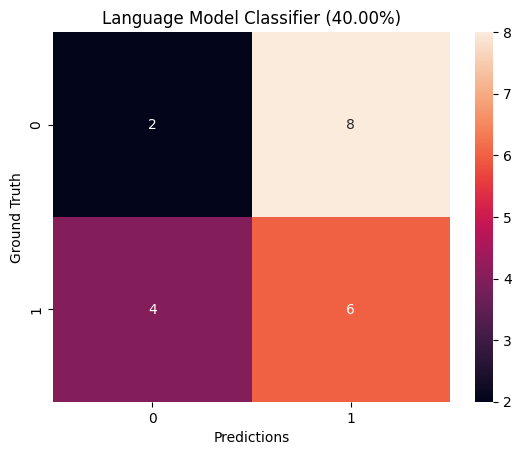

In [43]:
lm_accuracy = (np.array(all_pred) == np.array(all_y)).sum() / len(all_y)
lm_cm = confusion_matrix(all_y, all_pred)
sns.heatmap(lm_cm, annot=lm_cm)
plt.ylabel("Ground Truth")
plt.xlabel("Predictions")
plt.title(f"Language Model Classifier ({100 * lm_accuracy:.2f}%)")

#### 2.4-B End-to-End

In [44]:
loss_fn = nn.CrossEntropyLoss()

e2e_clf.eval()

loss = 0.
all_pred = []
all_y = []

for i, (X, y) in enumerate(clf_test_dl, start=1):

    # Use GPU
    X, y = X.to(device), y.to(device)

    with torch.no_grad():

        # Forward
        predictions = e2e_clf(X)

    # Gather data and report
    all_pred += torch.argmax(predictions, axis=1).tolist()
    all_y += y.tolist()

Text(0.5, 1.0, 'End-to-End Classifier (70.00%)')

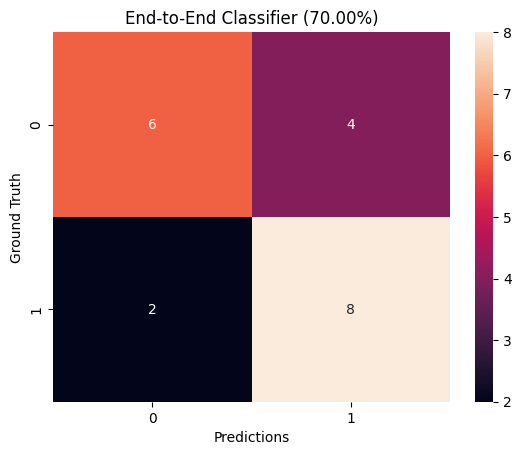

In [46]:
e2e_accuracy = (np.array(all_pred) == np.array(all_y)).sum() / len(all_y)
e2e_cm = confusion_matrix(all_y, all_pred)
sns.heatmap(e2e_cm, annot=e2e_cm)
plt.ylabel("Ground Truth")
plt.xlabel("Predictions")
plt.title(f"End-to-End Classifier ({100 * e2e_accuracy:.2f}%)")